In [1]:

import torch
import torch.nn as nn
import timm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


import sys
sys.path.append('../DataLoader')

from dataloader_fits import SunImageDataset

from lightning.fabric import Fabric

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

import scipy.stats as stats
import random

In [2]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch()
print(fabric.device)

Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

In [4]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
# hidden_size = 1024
num_epochs = 10
batch_size = 2
learning_rate = 0.002
dropout = 0.5
lstm_layers = 2

k_folds = 5

In [5]:
dataset = SunImageDataset(csv_file="D:\\New folder (2)\\dataset_full.csv", offset=0)

total_size = len(dataset)
fold_size = total_size // k_folds
indices = list(range(total_size))

k_fold_1_indices = indices[:fold_size]
k_fold_2_indices = indices[fold_size:2*fold_size]
k_fold_3_indices = indices[2*fold_size:3*fold_size]
k_fold_4_indices = indices[3*fold_size:4*fold_size]
k_fold_5_indices = indices[4*fold_size:]

print(len(k_fold_1_indices))
print(len(k_fold_2_indices))
print(len(k_fold_3_indices))
print(len(k_fold_4_indices))
print(len(k_fold_5_indices))

dataloaders = [k_fold_1_indices, k_fold_2_indices, k_fold_3_indices, k_fold_4_indices, k_fold_5_indices]

# Get date list 
kp_dates = pd.read_csv("D:\\New folder (2)\\matched_kp_dates_full.csv")
kp_dates_list = kp_dates["date"].tolist() 

1097
1097
1097
1097
1099


In [6]:
# Get active indices
dataset_csv_file = pd.read_csv("D:\\New folder (2)\\dataset_full.csv")
active_indices = []

for i in dataset_csv_file.index:
    if dataset_csv_file['Kp'][i] >= 3.667:
        active_indices.append(i)
        
active_dataloaders = []
for dataloader in dataloaders:
    active_dataloaders.append(list(set(dataloader) & set(active_indices)))
    
for dataloader in active_dataloaders:
    print(len(dataloader))

264
261
403
446
329


In [7]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()
        
        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)
        
        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )
        
        self.lstm = nn.LSTM(hidden_size, hidden_size * 2, lstm_layers, batch_first=True)
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_size*2, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
            # nn.LeakyReLU()
            
        )
    
    def forward(self, images) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """
        
        batch_size = images.shape[0]
        
        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, 10, -1)
        # hidden_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # cell_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # image_features, _ = self.lstm(image_features, (hidden_states, cell_states))
        image_features, _ = self.lstm(image_features)

        image_features = image_features[:, -1, :]
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()

In [8]:
torch.cuda.empty_cache()

In [9]:
def calculate_rates(all_outputs, all_labels):
    storm_labels = []
    for output in all_labels:
        if output < 3.667:
            storm_labels.append(0)
        else:
            storm_labels.append(1)
    storm_outputs = []
    for output in all_outputs:
        if output < 3.667:
            storm_outputs.append(0)
        else:
            storm_outputs.append(1)

    # Calculate true positive, true negative, false positive, false negative
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(storm_labels)):
        if storm_labels[i] == 1 and storm_outputs[i] == 1:
            tp += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 0:
            tn += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 1:
            fp += 1
        elif storm_labels[i] == 1 and storm_outputs[i] == 0:
            fn += 1
            
    return tp, tn, fp, fn


def true_skill_score(tp, tn, fp, fn):  
            
    # Calculate true skill score
    tss = (tp / (tp + fp)) - (fp / (fp + tn)) if ((tp > 0 and tn > 0) or fp > 0) else 0
    return tss
    
def calculate_metrics(tp, tn, fp, fn):
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    
    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return accuracy, precision, recall, f1





cuda:0
FOLD 1
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.1353233719353857


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.674456702780899


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.3607024274823725


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.6333995484984487


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.9840735815195362


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0578300545364447


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7750298375967208


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.207045715732372


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6217005763016913


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.9674506029993073


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5071881535302069


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.951178790438553


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.42017461277470514


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.3073369810068085


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3439488658640599


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2167944042230574


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.2949466770761499


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.232867627416611


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.26883445689713226


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2236688577213566


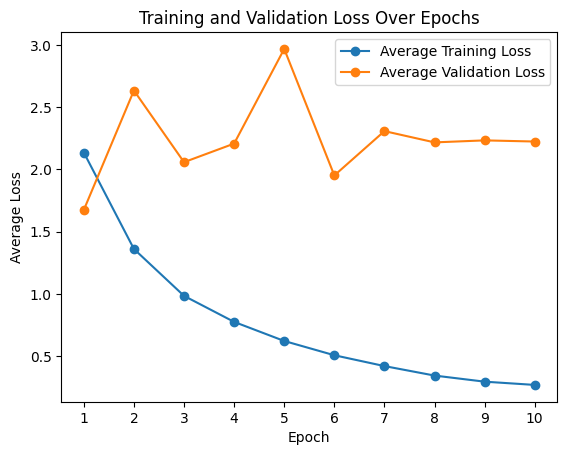

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.2237
RMSE: 1.4912
MSE: 2.2257
MAE: 1.1254
R²: -0.2284
R: 0.2102
True Skill Score: 0.2535
Accuracy: 0.7220
Precision: 0.3904
Recall: 0.2765
F1 Score: 0.3237


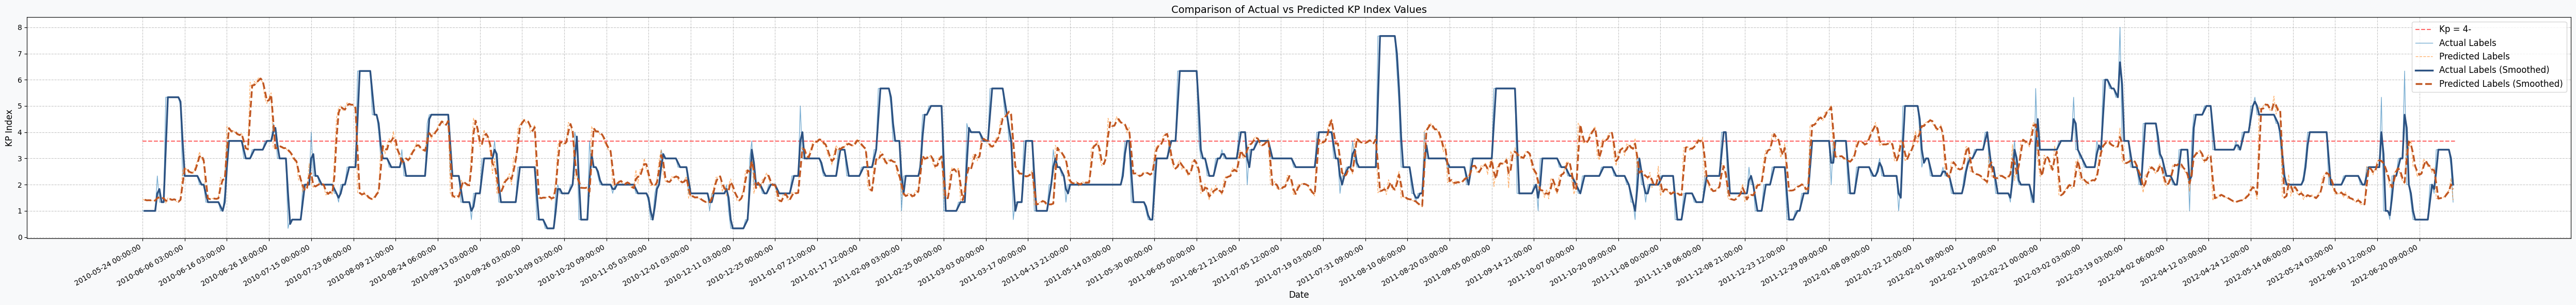

[1.4453125, 1.40625, 1.3984375, 1.4140625, 1.390625, 1.3828125, 1.40625, 1.5703125, 1.46875, 1.5, 1.4765625, 1.296875, 1.4921875, 1.4140625, 1.421875, 1.4609375, 1.359375, 1.3359375, 1.5078125, 2.53125, 2.6875, 2.5625, 2.4375, 2.484375, 2.421875, 2.6875, 2.890625, 3.25, 2.96875, 2.890625, 1.5, 1.453125, 1.4453125, 1.4765625, 1.4609375, 1.453125, 1.5078125, 2.28125, 2.09375, 2.328125, 4.21875, 4.09375, 4.0, 4.0625, 3.96875, 3.890625, 3.890625, 3.96875, 3.375, 3.390625, 3.3125, 5.90625, 5.65625, 5.9375, 5.84375, 6.09375, 6.0, 5.90625, 5.28125, 5.09375, 5.34375, 5.5, 3.390625, 3.375, 3.4375, 3.5, 3.375, 3.40625, 3.390625, 3.265625, 3.21875, 3.046875, 2.90625, 2.875, 2.171875, 2.234375, 1.703125, 1.859375, 1.875, 2.796875, 2.0625, 1.8984375, 1.9609375, 2.0, 2.046875, 2.046875, 1.9140625, 1.6015625, 1.6875, 1.7421875, 1.609375, 2.984375, 4.53125, 4.9375, 5.0, 4.8125, 4.90625, 5.125, 5.03125, 5.0625, 5.03125, 4.84375, 1.6875, 1.6796875, 1.578125, 1.7265625, 1.59375, 1.484375, 1.46875, 1.4218

Testing Progress:   0%|          | 0/132 [00:00<?, ?it/s]

Average test loss: 5.2751
RMSE: 2.2967
MSE: 5.2751
MAE: 1.8235
R²: -3.8571
R: -0.2559


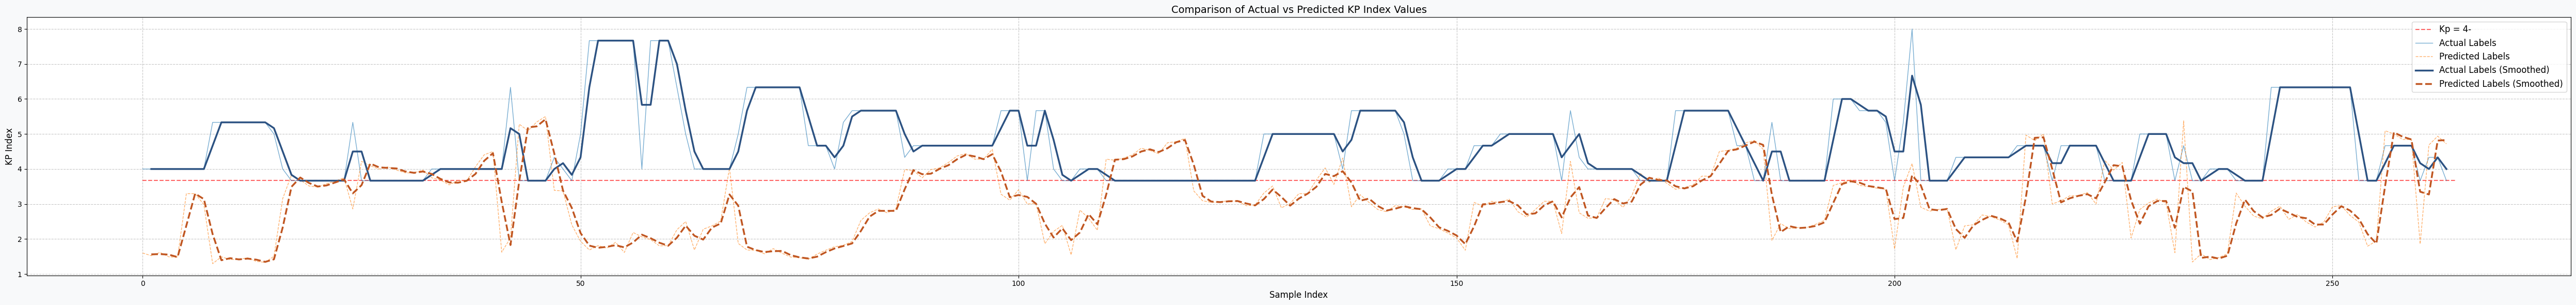

[1.6015625, 1.5234375, 1.6171875, 1.4921875, 1.4765625, 3.296875, 3.296875, 2.984375, 1.296875, 1.4921875, 1.4140625, 1.421875, 1.4609375, 1.359375, 1.3359375, 1.5078125, 3.15625, 3.828125, 3.6875, 3.515625, 3.484375, 3.578125, 3.65625, 3.75, 2.859375, 4.21875, 4.09375, 4.0, 4.0625, 3.96875, 3.890625, 3.890625, 3.96875, 3.75, 3.6875, 3.546875, 3.671875, 3.65625, 4.0625, 4.40625, 4.5, 1.625, 2.03125, 5.28125, 5.09375, 5.34375, 5.5, 3.390625, 3.375, 2.40625, 1.9375, 1.6875, 1.8125, 1.7421875, 1.90625, 1.6171875, 2.1875, 2.0625, 1.984375, 1.8046875, 1.8125, 2.265625, 2.5, 1.6875, 2.28125, 2.375, 2.515625, 4.03125, 1.875, 1.6875, 1.6796875, 1.578125, 1.7265625, 1.59375, 1.484375, 1.46875, 1.421875, 1.5703125, 1.6796875, 1.78125, 1.8203125, 1.9296875, 2.53125, 2.75, 2.859375, 2.75, 2.859375, 3.984375, 3.953125, 3.75, 3.984375, 4.03125, 4.1875, 4.375, 4.4375, 4.28125, 4.28125, 4.5625, 3.28125, 3.109375, 3.40625, 3.0, 3.015625, 1.8671875, 2.21875, 2.390625, 1.546875, 2.828125, 2.59375, 2.25, 

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.0200020599508592


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.078059006871792


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.3099857886518493


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.480083975619581


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.0076674745799465


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2346165756219345


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7353297234081545


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1781216652012976


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5522242340306324


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.224893116135191


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4686999766963692


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.3759773262402804


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3786593631179511


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2463323122931804


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.29266795145073515


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.138310217381903


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.2541524254307142


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.3580661391485687


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.23683279378214664


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.4466007808433297


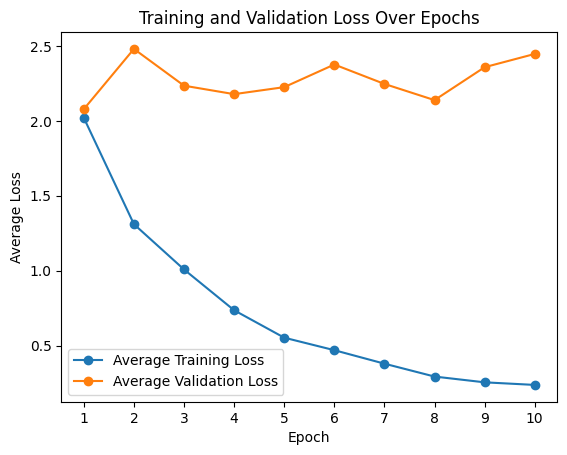

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.4466
RMSE: 1.5642
MSE: 2.4487
MAE: 1.2826
R²: -0.2485
R: 0.1965
True Skill Score: 0.1688
Accuracy: 0.6983
Precision: 0.3554
Recall: 0.3295
F1 Score: 0.3419


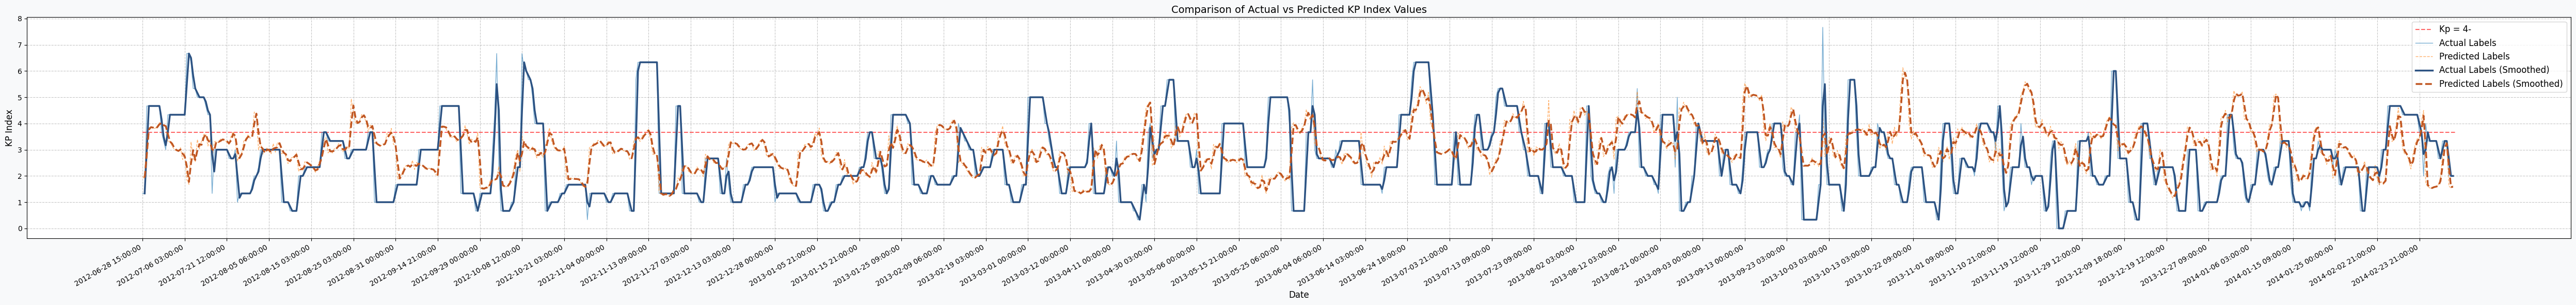

[1.984375, 1.890625, 3.6875, 3.84375, 3.875, 3.8125, 3.8125, 3.90625, 4.03125, 4.0, 3.875, 3.921875, 3.296875, 3.328125, 3.140625, 3.015625, 2.96875, 2.9375, 3.078125, 2.625, 2.875, 1.859375, 1.6796875, 3.296875, 2.671875, 2.546875, 3.390625, 3.03125, 3.34375, 3.578125, 3.59375, 3.140625, 3.40625, 2.625, 3.296875, 3.328125, 3.265625, 3.40625, 3.375, 3.375, 3.28125, 3.203125, 3.515625, 3.6875, 3.375, 2.5625, 2.796875, 2.84375, 3.328125, 3.421875, 3.5625, 3.4375, 3.546875, 4.4375, 4.3125, 3.0, 3.25, 2.828125, 2.921875, 3.0625, 2.9375, 2.84375, 3.234375, 2.90625, 3.28125, 3.21875, 2.84375, 2.921875, 2.734375, 2.46875, 2.65625, 2.703125, 2.75, 2.875, 2.171875, 2.328125, 2.21875, 2.546875, 2.484375, 2.4375, 2.359375, 2.28125, 2.140625, 2.34375, 2.578125, 2.8125, 3.34375, 3.46875, 2.875, 3.0, 2.875, 3.046875, 3.046875, 3.234375, 3.125, 2.921875, 3.0625, 3.140625, 3.03125, 4.9375, 4.4375, 4.03125, 4.0, 4.125, 4.34375, 4.28125, 4.0625, 3.6875, 3.9375, 3.875, 3.25, 3.234375, 3.140625, 3.140625,

Testing Progress:   0%|          | 0/131 [00:00<?, ?it/s]

Average test loss: 2.7972
RMSE: 1.6725
MSE: 2.8070
MAE: 1.4123
R²: -3.1481
R: 0.0686


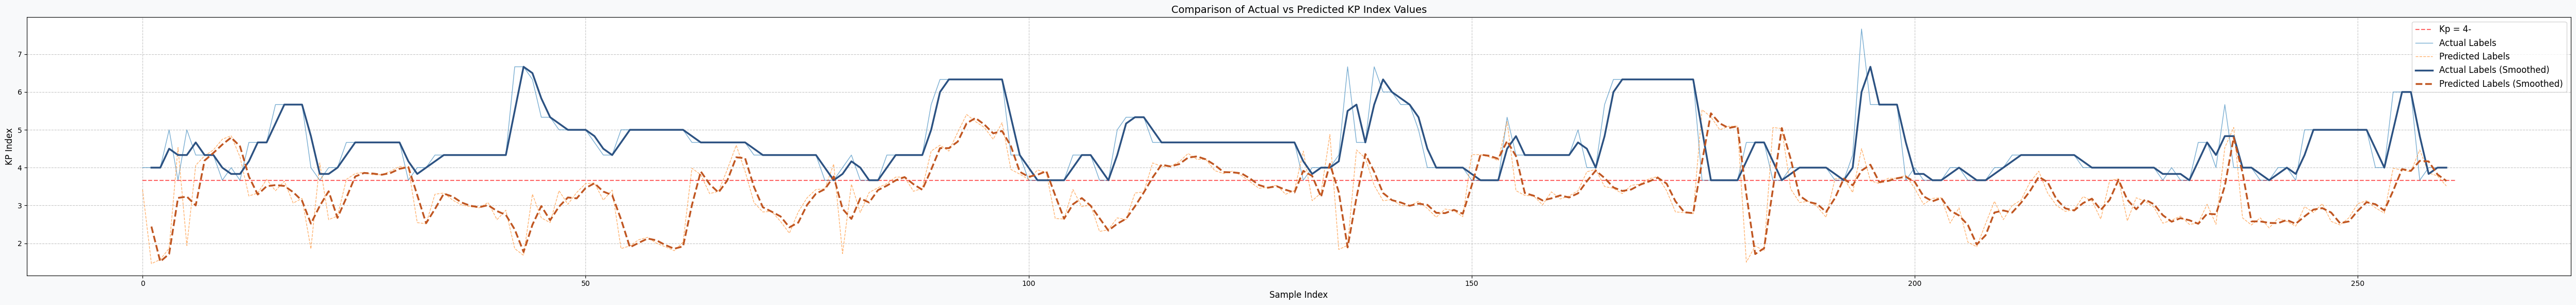

[3.421875, 1.4609375, 1.5703125, 1.8671875, 4.53125, 1.9375, 4.0625, 4.3125, 4.46875, 4.75, 4.84375, 4.28125, 3.25, 3.328125, 3.6875, 3.390625, 3.640625, 3.0625, 3.1875, 1.8515625, 4.125, 2.625, 2.71875, 3.6875, 3.84375, 3.875, 3.8125, 3.8125, 3.90625, 4.03125, 4.0, 2.546875, 2.515625, 3.296875, 3.328125, 3.140625, 3.015625, 2.96875, 2.9375, 3.078125, 2.625, 2.875, 1.859375, 1.6796875, 3.296875, 2.671875, 2.546875, 3.390625, 3.03125, 3.34375, 3.578125, 3.59375, 3.140625, 3.40625, 1.859375, 1.9296875, 2.09375, 2.15625, 2.0, 1.90625, 1.8046875, 2.03125, 3.984375, 3.8125, 3.3125, 3.375, 3.953125, 4.59375, 3.90625, 3.078125, 2.828125, 2.84375, 2.578125, 2.265625, 2.828125, 3.203125, 3.421875, 3.4375, 4.09375, 1.7265625, 3.5625, 2.8125, 3.34375, 3.46875, 3.578125, 3.75, 3.75, 3.375, 3.453125, 4.4375, 4.59375, 4.4375, 4.9375, 5.40625, 5.21875, 5.0625, 4.75, 5.1875, 3.953125, 3.828125, 3.6875, 3.9375, 3.875, 2.65625, 2.640625, 3.421875, 2.96875, 3.015625, 2.3125, 2.359375, 2.671875, 2.625, 3.

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.0586797559028307


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7682325952507094


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.3837223001022279


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0281826573695887


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.0141549156317626


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.490989075630109


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7544071528729256


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9419363794938655


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5668087923684495


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.345454037455182


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.48611090833319953


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.134458810092503


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.37332670659999995


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0592565040590958


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.2990146164014541


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2792451503311915


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.25395519053323484


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.208606981866584


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.22267575771974965


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1606177364770627


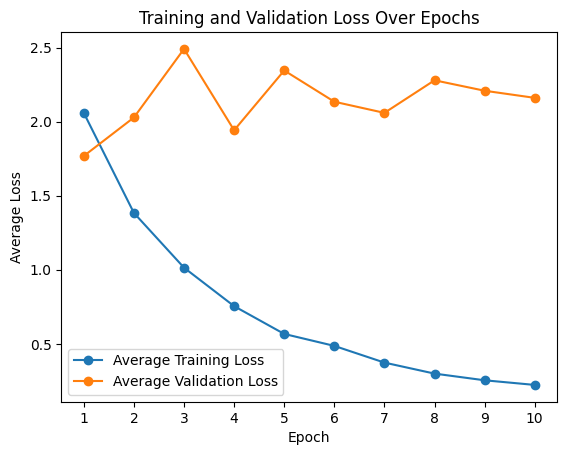

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.1606
RMSE: 1.4699
MSE: 2.1613
MAE: 1.1542
R²: -0.1456
R: 0.2431
True Skill Score: 0.5271
Accuracy: 0.6527
Precision: 0.5948
Recall: 0.1712
F1 Score: 0.2659


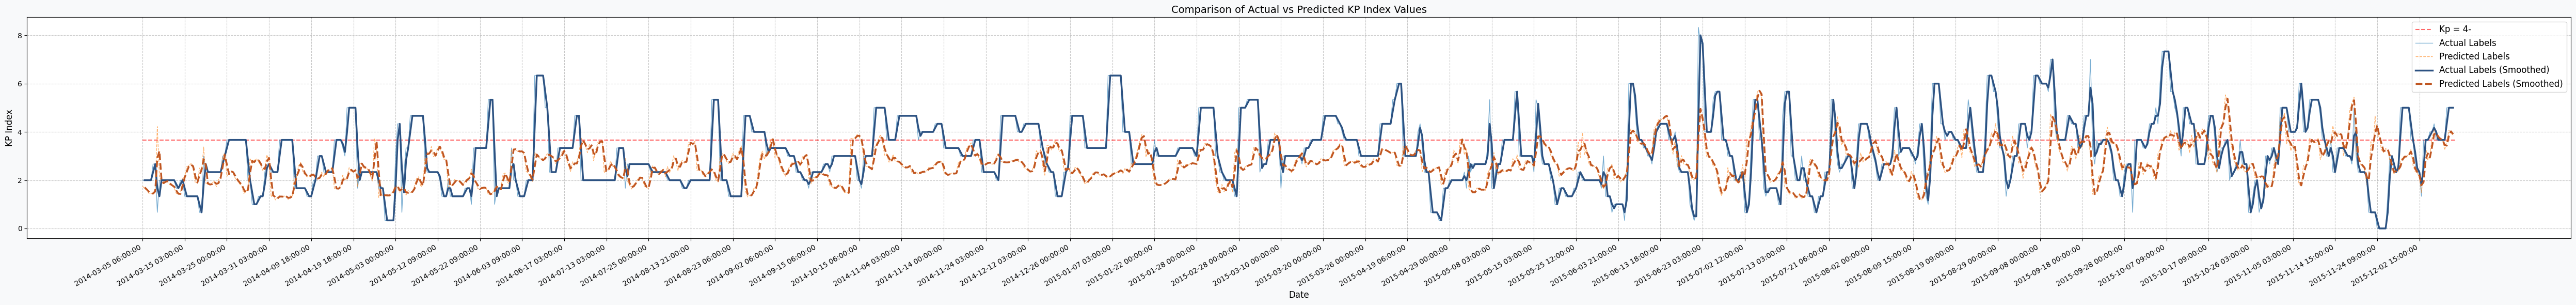

[1.75, 1.6484375, 1.5859375, 1.453125, 1.4453125, 1.4453125, 1.625, 4.21875, 2.1875, 1.8671875, 1.8828125, 1.9921875, 1.921875, 1.8046875, 1.7734375, 1.6875, 1.453125, 1.421875, 1.4375, 2.09375, 2.140625, 2.5625, 2.59375, 2.6875, 2.46875, 1.8828125, 1.9140625, 2.5, 2.359375, 3.375, 1.875, 1.84375, 1.796875, 1.875, 1.96875, 1.734375, 2.015625, 2.140625, 2.953125, 3.140625, 2.15625, 2.34375, 2.390625, 2.265625, 2.078125, 1.9765625, 1.84375, 1.796875, 1.453125, 1.515625, 1.6796875, 2.90625, 2.6875, 2.8125, 2.890625, 2.765625, 2.625, 2.40625, 2.515625, 3.046875, 2.796875, 1.3046875, 1.421875, 1.1796875, 1.2890625, 1.3515625, 1.2890625, 1.3359375, 1.34375, 1.1953125, 1.3515625, 1.3046875, 2.171875, 2.109375, 2.59375, 2.734375, 2.34375, 2.234375, 2.140625, 2.140625, 2.265625, 2.203125, 2.078125, 2.046875, 2.140625, 2.328125, 2.125, 2.390625, 2.421875, 2.40625, 2.5625, 1.65625, 1.65625, 1.640625, 1.796875, 2.203125, 1.984375, 2.15625, 2.515625, 2.34375, 2.359375, 2.453125, 1.7421875, 2.71875,

Testing Progress:   0%|          | 0/202 [00:00<?, ?it/s]

Average test loss: 4.0843
RMSE: 2.0210
MSE: 4.0910
MAE: 1.7448
R²: -4.1333
R: 0.1620


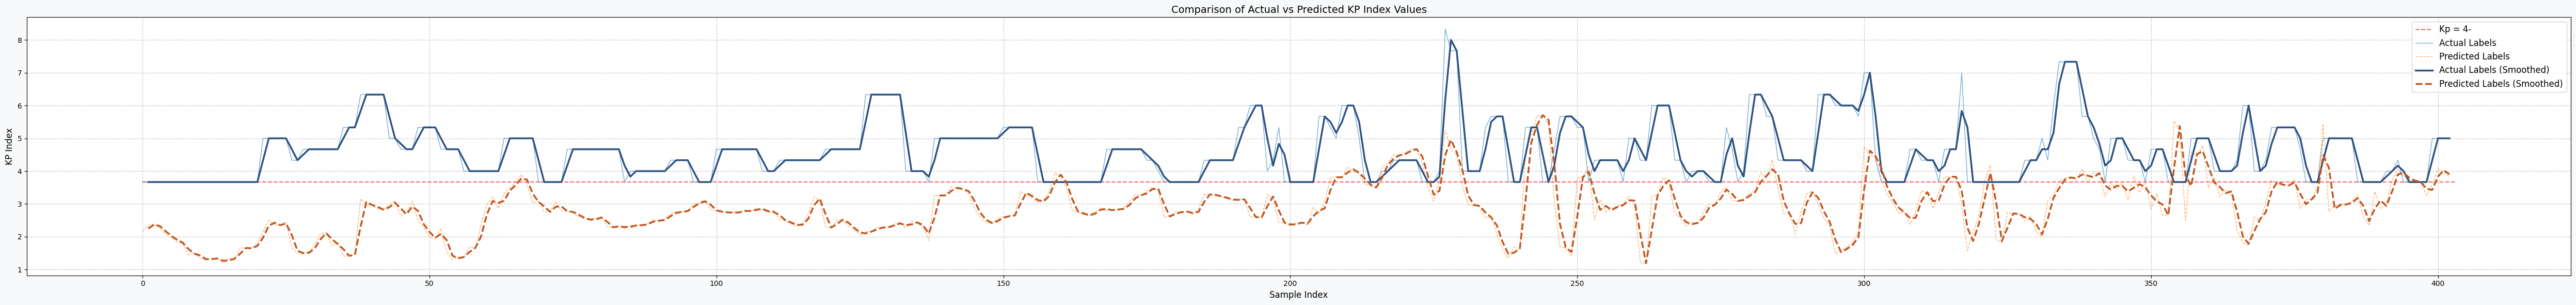

[2.15625, 2.34375, 2.390625, 2.265625, 2.078125, 1.9765625, 1.84375, 1.796875, 1.453125, 1.515625, 1.3515625, 1.2890625, 1.3359375, 1.34375, 1.1953125, 1.3515625, 1.3046875, 1.65625, 1.65625, 1.640625, 1.796875, 2.15625, 2.515625, 2.34375, 2.359375, 2.453125, 1.65625, 1.5, 1.4921875, 1.53125, 1.7578125, 2.078125, 2.140625, 1.71875, 1.8359375, 1.40625, 1.4296875, 1.46875, 3.15625, 2.96875, 2.96875, 2.84375, 2.8125, 2.984375, 3.09375, 2.625, 2.75, 3.09375, 2.484375, 2.28125, 2.015625, 1.921875, 2.25, 1.546875, 1.3046875, 1.375, 1.390625, 1.6875, 1.640625, 2.390625, 2.96875, 3.203125, 2.859375, 3.328125, 3.484375, 3.65625, 3.890625, 3.59375, 3.03125, 3.09375, 2.75, 2.765625, 3.0625, 2.78125, 2.78125, 2.734375, 2.609375, 2.546875, 2.5, 2.5625, 2.609375, 2.296875, 2.28125, 2.34375, 2.25, 2.34375, 2.34375, 2.359375, 2.390625, 2.53125, 2.453125, 2.5625, 2.6875, 2.765625, 2.75, 2.8125, 3.0, 3.03125, 3.125, 2.828125, 2.78125, 2.75, 2.734375, 2.734375, 2.75, 2.8125, 2.765625, 2.875, 2.828125, 2.

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.0819902620185484


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8845217153036766


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.5127507255930275


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.4979461950128254


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.0779024441657823


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8017459146632644


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7798499133057202


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.5896344339751336


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6266941531665797


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.679583086187431


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.48093082567395545


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.5484024309977305


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3906799569696157


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.675741841706349


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.35608057948968574


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7335440168189664


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.31594132724562013


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6412680654486265


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.26185225850571947


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6402182997887587


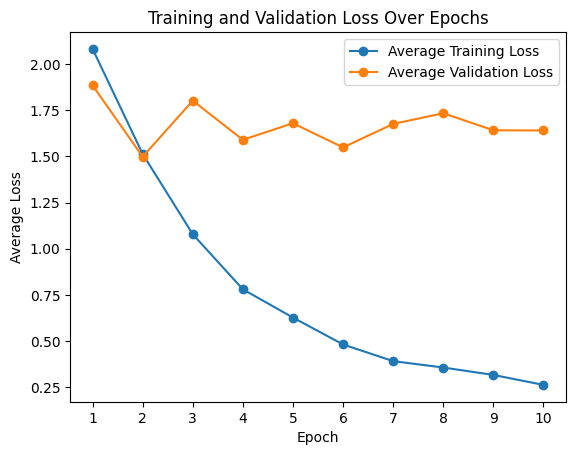

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 1.6402
RMSE: 1.2807
MSE: 1.6413
MAE: 1.0275
R²: 0.1053
R: 0.4612
True Skill Score: 0.4242
Accuracy: 0.6855
Precision: 0.6347
Recall: 0.5336
F1 Score: 0.5798


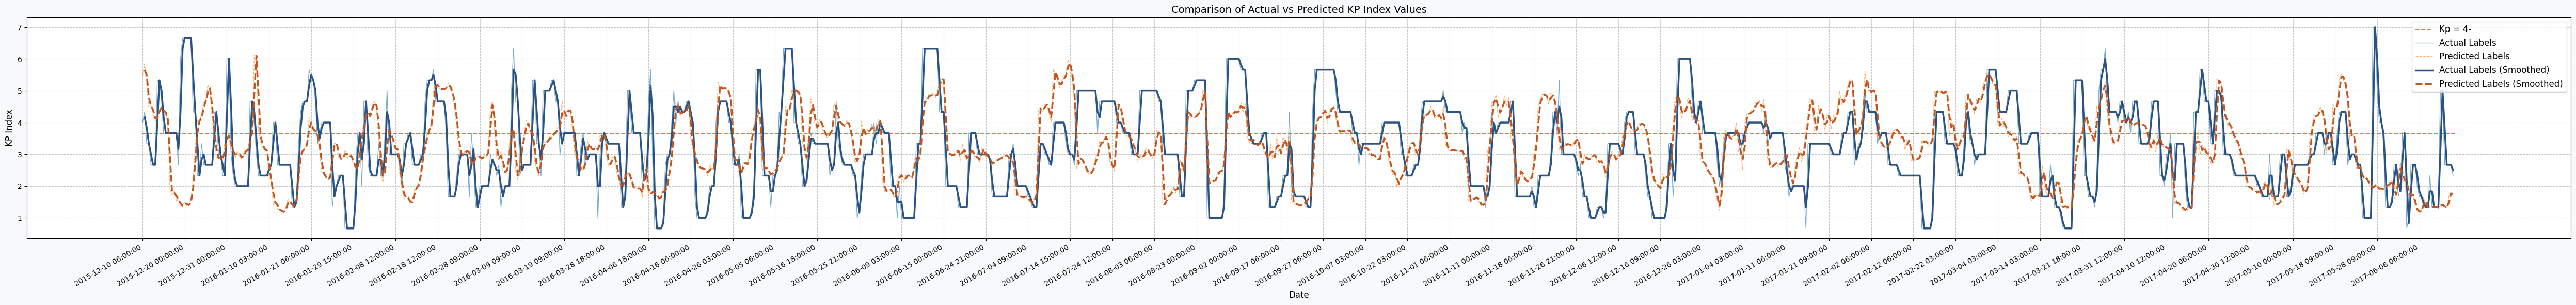

[5.46875, 5.84375, 5.125, 4.46875, 4.5625, 4.25, 4.03125, 4.21875, 4.46875, 4.46875, 4.3125, 4.3125, 3.890625, 1.9140625, 1.7109375, 1.8671875, 1.5234375, 1.6015625, 1.34375, 1.4140625, 1.5, 1.3828125, 1.4296875, 1.5859375, 2.28125, 3.21875, 4.09375, 4.0, 4.28125, 4.625, 4.71875, 5.1875, 4.96875, 4.09375, 3.53125, 2.875, 2.90625, 2.875, 2.8125, 3.390625, 3.546875, 3.625, 3.0625, 3.125, 2.890625, 3.09375, 2.9375, 2.859375, 3.03125, 3.15625, 3.09375, 3.640625, 3.703125, 6.125, 6.0625, 3.75, 3.390625, 3.234375, 3.09375, 3.140625, 2.234375, 2.1875, 1.40625, 1.5625, 1.2734375, 1.2421875, 1.1875, 1.1796875, 1.3359375, 1.59375, 1.4609375, 1.375, 1.4140625, 1.609375, 2.78125, 3.09375, 3.125, 3.21875, 3.40625, 4.15625, 3.84375, 3.75, 3.703125, 3.515625, 3.09375, 2.4375, 2.375, 2.234375, 2.171875, 2.390625, 3.1875, 3.34375, 3.328125, 2.890625, 2.84375, 2.875, 3.140625, 2.890625, 2.953125, 2.953125, 2.65625, 2.578125, 2.484375, 3.296875, 3.65625, 3.984375, 4.5, 4.15625, 4.25, 4.59375, 4.65625, 4.

Testing Progress:   0%|          | 0/223 [00:00<?, ?it/s]

Average test loss: 2.1202
RMSE: 1.4561
MSE: 2.1202
MAE: 1.1622
R²: -2.3396
R: 0.1691


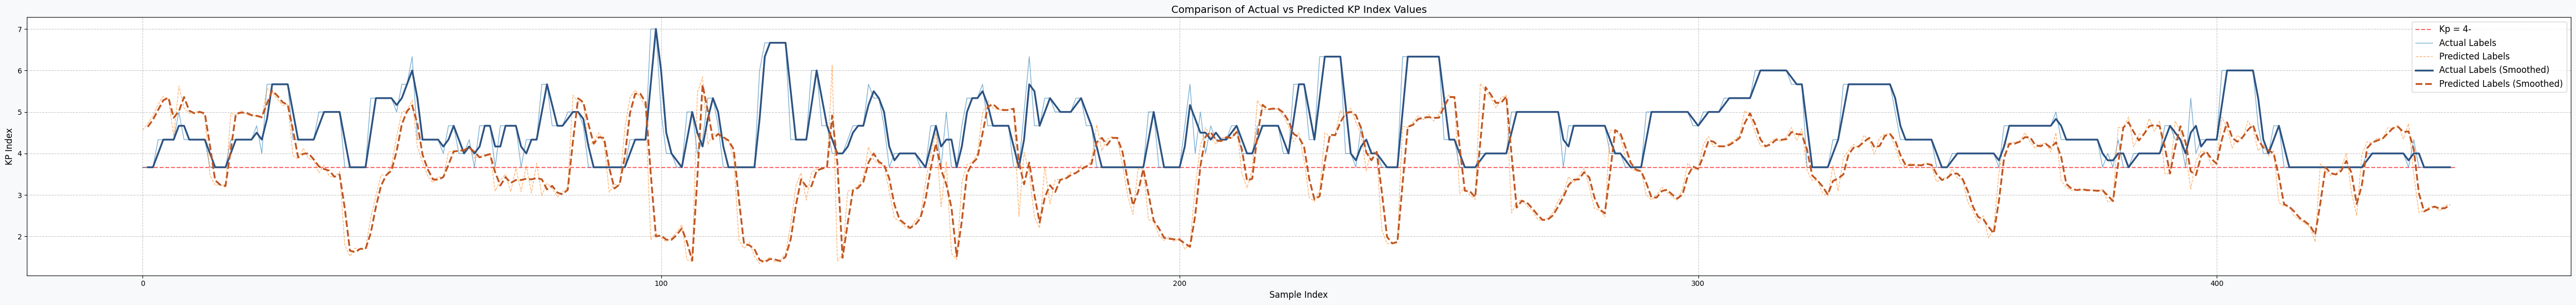

[4.5625, 4.71875, 4.90625, 5.1875, 5.375, 5.3125, 4.40625, 5.625, 5.09375, 4.96875, 4.96875, 5.03125, 4.90625, 3.46875, 3.234375, 3.25, 3.1875, 4.96875, 4.9375, 5.03125, 4.9375, 4.90625, 4.90625, 4.84375, 5.5625, 5.46875, 5.3125, 5.15625, 5.1875, 3.953125, 3.859375, 4.125, 3.875, 3.84375, 3.53125, 3.71875, 3.453125, 3.421875, 3.5625, 1.7890625, 1.5234375, 1.71875, 1.6875, 1.703125, 2.453125, 2.96875, 3.484375, 3.46875, 3.703125, 4.40625, 5.0, 5.03125, 5.28125, 4.15625, 3.78125, 3.453125, 3.296875, 3.4375, 3.421875, 4.03125, 4.0625, 4.0625, 4.09375, 4.1875, 3.890625, 3.921875, 3.96875, 4.0, 3.09375, 3.359375, 3.5, 3.078125, 3.640625, 3.078125, 3.703125, 3.046875, 3.765625, 2.984375, 3.28125, 3.15625, 2.953125, 3.078125, 3.171875, 5.40625, 5.25, 5.21875, 4.1875, 4.28125, 4.5, 4.25, 3.0625, 3.25, 3.25, 4.59375, 5.34375, 5.53125, 5.34375, 5.125, 1.921875, 2.078125, 1.96875, 1.875, 1.9609375, 2.109375, 2.28125, 1.4375, 1.3984375, 5.46875, 5.84375, 4.21875, 4.46875, 4.46875, 4.3125, 4.3125, 

Training Progress: Epoch: 1:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  2.110579597898717


Validation Progress: Epoch: 1:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.418241035404975


Training Progress: Epoch: 2:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.4478322371575225


Validation Progress: Epoch: 2:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.3648427051903722


Training Progress: Epoch: 3:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.0897562918462038


Validation Progress: Epoch: 3:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.4953140122495294


Training Progress: Epoch: 4:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.8130770698884832


Validation Progress: Epoch: 4:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.387990852332666


Training Progress: Epoch: 5:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.6191886607584596


Validation Progress: Epoch: 5:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.7402941774141139


Training Progress: Epoch: 6:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.49576048720323884


Validation Progress: Epoch: 6:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.4931253464922272


Training Progress: Epoch: 7:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.4094325350986171


Validation Progress: Epoch: 7:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5533966974229472


Training Progress: Epoch: 8:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.3737059268739434


Validation Progress: Epoch: 8:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5796730344252534


Training Progress: Epoch: 9:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.3098480941053982


Validation Progress: Epoch: 9:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.6313015272186815


Training Progress: Epoch: 10:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.26205703048244827


Validation Progress: Epoch: 10:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.503273663515204


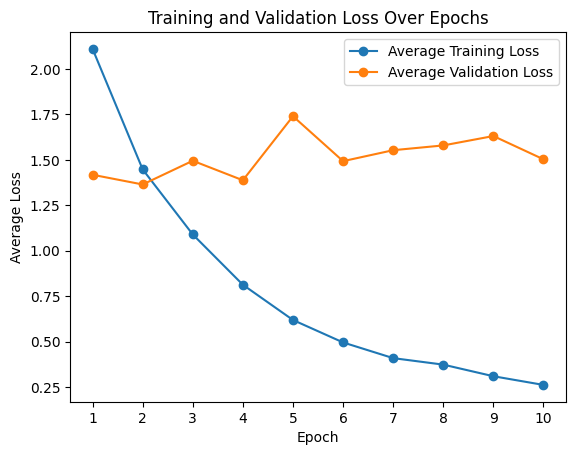

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/550 [00:00<?, ?it/s]

Average test loss: 1.5033
RMSE: 1.2261
MSE: 1.5041
MAE: 0.9403
R²: 0.1468
R: 0.4320
True Skill Score: 0.7354
Accuracy: 0.7480
Precision: 0.7653
Recall: 0.2280
F1 Score: 0.3513


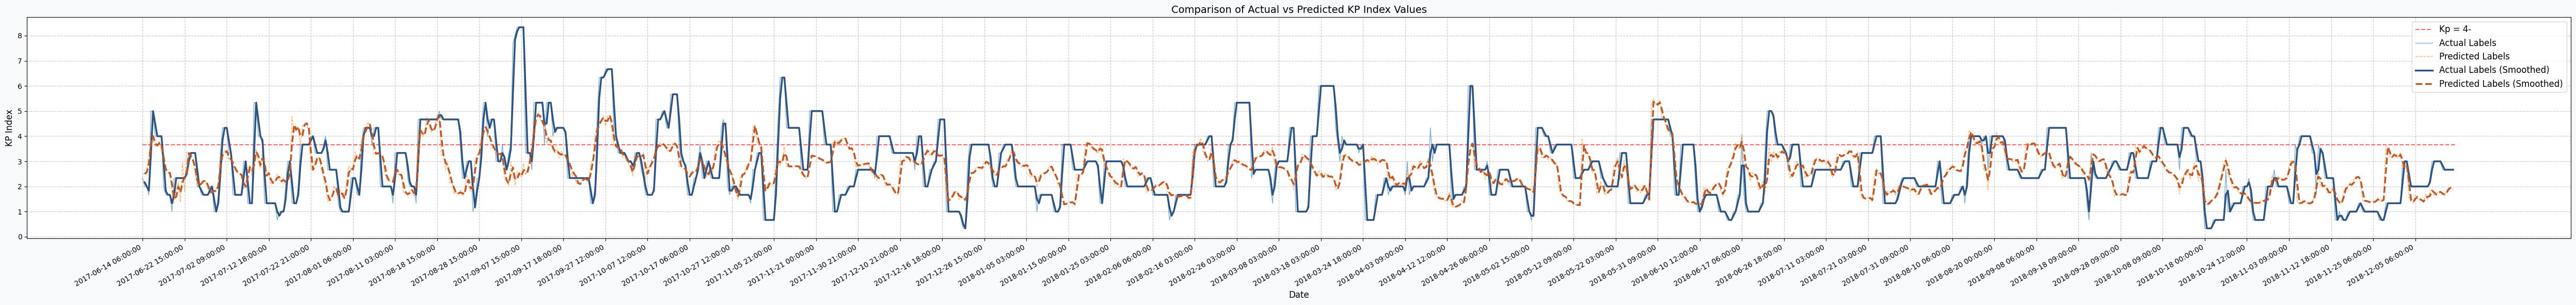

[2.5, 2.5, 2.625, 3.1875, 4.15625, 3.859375, 3.59375, 3.65625, 3.796875, 3.453125, 2.90625, 2.5, 2.578125, 2.5, 1.6875, 1.34375, 1.84375, 2.15625, 1.375, 2.953125, 1.8046875, 3.375, 3.28125, 3.15625, 2.953125, 2.546875, 1.984375, 2.0625, 2.171875, 2.25, 2.203125, 1.921875, 1.671875, 1.859375, 1.7890625, 1.828125, 2.203125, 3.328125, 3.15625, 3.453125, 3.359375, 3.0625, 3.078125, 2.8125, 2.65625, 2.53125, 2.53125, 2.390625, 1.9140625, 2.0625, 2.671875, 2.859375, 2.4375, 3.25, 3.5, 2.953125, 2.734375, 3.515625, 2.28125, 2.578125, 2.484375, 2.078125, 2.203125, 2.1875, 2.5, 2.265625, 2.15625, 2.359375, 2.015625, 2.421875, 2.578125, 4.78125, 4.125, 4.375, 4.375, 3.625, 4.4375, 4.46875, 4.5625, 4.125, 2.6875, 2.640625, 3.03125, 3.1875, 3.125, 2.640625, 2.375, 1.984375, 1.390625, 1.515625, 1.6328125, 2.03125, 1.796875, 1.5390625, 1.875, 1.5546875, 1.5, 2.25, 2.8125, 2.640625, 2.71875, 3.375, 3.109375, 3.09375, 3.828125, 4.125, 4.25, 4.5625, 4.375, 3.9375, 3.265625, 3.328125, 3.328125, 3.25, 3

Testing Progress:   0%|          | 0/165 [00:00<?, ?it/s]

Average test loss: 2.9205
RMSE: 1.7089
MSE: 2.9257
MAE: 1.3775
R²: -2.7859
R: 0.2483


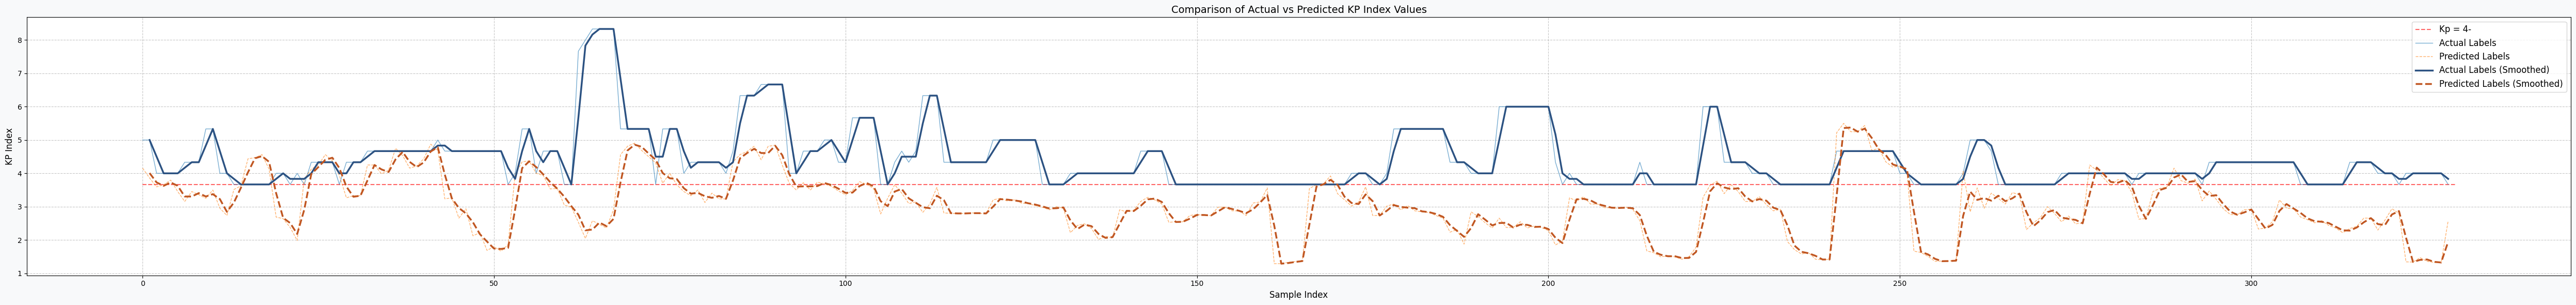

[4.15625, 3.859375, 3.59375, 3.65625, 3.796875, 3.453125, 3.15625, 3.453125, 3.359375, 3.25, 3.5, 2.953125, 2.734375, 3.515625, 3.625, 4.4375, 4.46875, 4.5625, 4.125, 2.6875, 2.640625, 2.375, 1.984375, 3.828125, 4.125, 4.25, 4.5625, 4.375, 3.9375, 3.265625, 3.328125, 3.328125, 4.25, 4.25, 3.984375, 4.09375, 4.75, 4.53125, 4.15625, 4.21875, 4.4375, 4.875, 4.6875, 3.234375, 3.265625, 2.65625, 2.9375, 2.125, 2.21875, 1.6875, 1.796875, 1.6640625, 1.859375, 3.96875, 4.34375, 4.375, 4.0, 3.9375, 3.53125, 3.546875, 3.046875, 2.984375, 2.53125, 2.046875, 2.578125, 2.46875, 2.359375, 2.90625, 4.5625, 4.8125, 4.90625, 4.6875, 4.5, 4.3125, 3.703125, 4.0, 3.65625, 3.453125, 3.328125, 3.5, 3.125, 3.40625, 3.234375, 3.234375, 4.34375, 4.5625, 4.65625, 4.8125, 4.40625, 4.8125, 4.84375, 4.25, 3.703125, 3.5, 3.71875, 3.5, 3.734375, 3.6875, 3.609375, 3.46875, 3.359375, 3.484375, 3.75, 3.671875, 3.546875, 2.78125, 3.25, 3.65625, 3.40625, 3.09375, 3.140625, 2.828125, 3.078125, 3.578125, 2.8125, 2.796875, 

In [10]:

print(fabric.device)
total_avg_test_loss = 0
total_rmse = 0
total_mse = 0
total_mae = 0
total_r2 = 0
total_r = 0
total_tts = 0
total_accuracy = 0
total_precision = 0
total_recall = 0
total_f1 = 0

active_total_avg_test_loss = 0
active_total_rmse = 0
active_total_mse = 0
active_total_mae = 0
active_total_r2 = 0
active_total_r = 0


for i in range(k_folds):
    print(f'FOLD {i + 1}')
    print('--------------------------------')
    test_indices = dataloaders[i]
    active_test_indices = active_dataloaders[i]
    train_indices = []
    for j in range(k_folds):
        if j != i:
            train_indices += dataloaders[j]
    generator = torch.Generator().manual_seed(42)
    trainloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=20, prefetch_factor=6, pin_memory=True, generator=generator)
    testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
    active_testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, active_test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
    trainloader = fabric.setup_dataloaders(trainloader)
    testloader = fabric.setup_dataloaders(testloader)
    active_testloader = fabric.setup_dataloaders(active_testloader)


    # Reinitialize model
    model = GmiSwinTransformer(hidden_size=hidden_size)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    model, optimizer = fabric.setup(model, optimizer)
    model.train()

    # Training the model
    n_total_steps = len(trainloader)
    avg_train_loss_over_epochs = []
    avg_val_loss_over_epochs = []

    for epoch in range(num_epochs):
        train_losses = []
        val_losses = []

        # Training loop
        model.train()
        for i, (images, labels) in tqdm(enumerate(trainloader), desc=f"Training Progress: Epoch: {epoch + 1}", total=len(trainloader)):
            # Move images and labels to device
            images = images.float()
            labels = labels.float()

            # Forward pass with autograd
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            # tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

            # Backward pass and optimization
            optimizer.zero_grad()
            fabric.backward(loss)
            optimizer.step()
            # Store the loss
            train_losses.append(loss.item())

        # Store the average training loss for this epoch
        avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
        print("Average Training Loss: ", sum(train_losses) / len(train_losses))

        # Validation loop
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(testloader, desc=f"Validation Progress: Epoch: {epoch + 1}", total=len(testloader)):
                images = images.float()
                # images = images.permute(1, 0, 2, 3, 4)
                labels = labels.float()
                outputs = model(images).squeeze(1)
                loss = criterion(outputs, labels)
                # print("Validation Loss: ", loss.item())
                val_losses.append(loss.item())

        # Store the average validation loss for this epoch
        avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))
        print("Average Validation Loss: ", sum(val_losses) / len(val_losses))

    # Plot loss over epochs
    plt.figure()
    plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
    plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.title('Training and Validation Loss Over Epochs')
    plt.show()

    test_losses = []
    all_labels = []
    all_outputs = []

    model.eval()

    print('--------------------------------')
    print('Test for Full set')
    print('--------------------------------')

# Test for Full set
    with torch.no_grad():
        for images, labels in tqdm(testloader, desc="Testing Progress"):
            images = images.float()
            # images = images.permute(1, 0, 2, 3, 4)
            labels = labels.float()
            # print("Label: ", labels)
            outputs = model(images).squeeze(1)
            # print("Output: ", outputs)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    avg_test_loss = sum(test_losses) / len(test_losses)
    rmse = math.sqrt(avg_test_loss)
    mse = mean_squared_error(all_labels, all_outputs)
    mae = mean_absolute_error(all_labels, all_outputs)
    r2 = r2_score(all_labels, all_outputs)
    r, _ = stats.pearsonr(all_labels, all_outputs)
    tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
    accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
    tts = true_skill_score(tp, tn, fp, fn)



    # Accumulate metrics for averaging across folds
    total_avg_test_loss += avg_test_loss
    total_rmse += rmse
    total_mse += mse
    total_mae += mae
    total_r2 += r2
    total_r += r
    total_tts += tts
    total_accuracy += accuracy
    total_precision += precision
    total_recall += recall
    total_f1 += f1


    print(f'Average test loss: {avg_test_loss:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R²: {r2:.4f}')
    print(f'R: {r:.4f}')
    print(f'True Skill Score: {tts:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    test_dates = list(kp_dates_list[i] for i in test_indices)
    # Convert to pandas Series for easy rolling average calculation
    labels_series = pd.Series(all_labels)
    outputs_series = pd.Series(all_outputs)

    # Calculate rolling averages with window size of 5
    window_size = 2
    labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
    outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

    # Create a better-looking plot
    plt.figure(figsize=(50, 6), facecolor='#f8f9fa')
    plt.plot([0, len(test_dates)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')
    # Plot original data with thin lines
    plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
    plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

    # Plot smoothed data with thicker lines
    plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
    plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

    # Format x-axis with dates
    test_dates_sliced = test_dates[0:len(all_labels):20]
    plt.xticks(range(0, len(test_dates), 20), test_dates_sliced, rotation=30, ha='right')

    # Better grid styling
    plt.grid(True, linestyle='--', alpha=0.7)

    # Improve labels and title
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('KP Index', fontsize=12)
    plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

    # Better legend
    plt.legend(loc='best', frameon=True, fontsize=12)

    # Adjust layout for better spacing
    plt.tight_layout()

    plt.show()
    print(all_outputs)

    print('--------------------------------')
    print('Test for Active Periods')
    print('--------------------------------')

    test_losses = []
    all_labels = []
    all_outputs = []

# Test for active periods
    with torch.no_grad():
        for images, labels in tqdm(active_testloader, desc="Testing Progress"):
            images = images.float()
            labels = labels.float()
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    avg_test_loss = sum(test_losses) / len(test_losses)
    rmse = math.sqrt(avg_test_loss)
    mse = mean_squared_error(all_labels, all_outputs)
    mae = mean_absolute_error(all_labels, all_outputs)
    r2 = r2_score(all_labels, all_outputs)
    r, _ = stats.pearsonr(all_labels, all_outputs)



    # Accumulate metrics for averaging across folds
    active_total_avg_test_loss += avg_test_loss
    active_total_rmse += rmse
    active_total_mse += mse
    active_total_mae += mae
    active_total_r2 += r2
    active_total_r += r




    print(f'Average test loss: {avg_test_loss:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R²: {r2:.4f}')
    print(f'R: {r:.4f}')
    # Convert to pandas Series for easy rolling average calculation
    labels_series = pd.Series(all_labels)
    outputs_series = pd.Series(all_outputs)

    # Calculate rolling averages with a window size of 5
    window_size = 2
    labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
    outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

    # Create a better-looking plot
    plt.figure(figsize=(50, 6), facecolor='#f8f9fa')

    plt.plot([0, len(all_labels)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')

    # Plot original data with thin lines
    plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
    plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

    # Plot smoothed data with thicker lines
    plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
    plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

    # Better grid styling
    plt.grid(True, linestyle='--', alpha=0.7)

    # Improve labels and title
    plt.xlabel('Sample Index', fontsize=12)
    plt.ylabel('KP Index', fontsize=12)
    plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

    # Better legend
    plt.legend(loc='best', frameon=True, fontsize=12)

    # Adjust layout for better spacing
    plt.tight_layout()

    plt.show()
    print(all_outputs)


print('--------------------------------')
print('Metrics for Full Set')
print('--------------------------------')

# Average metrics across all folds
total_avg_test_loss /= k_folds
total_rmse /= k_folds
total_mse /= k_folds
total_mae /= k_folds
total_r2 /= k_folds
total_r /= k_folds
total_tts /= k_folds
total_accuracy /= k_folds
total_precision /= k_folds
total_recall /= k_folds
total_f1 /= k_folds

print(f'Average test loss across all folds: {total_avg_test_loss:.4f}')
print(f'Average RMSE across all folds: {total_rmse:.4f}')
print(f'Average MSE across all folds: {total_mse:.4f}')
print(f'Average MAE across all folds: {total_mae:.4f}')
print(f'Average R² across all folds: {total_r2:.4f}')
print(f'Average R across all folds: {total_r:.4f}')
print(f'Average True Skill Score across all folds: {total_tts:.4f}')
print(f'Average Accuracy across all folds: {total_accuracy:.4f}')
print(f'Average Precision across all folds: {total_precision:.4f}')
print(f'Average Recall across all folds: {total_recall:.4f}')
print(f'Average F1 Score across all folds: {total_f1:.4f}')

print('--------------------------------')
print('Metrics for Active Periods')
print('--------------------------------')
# Average metrics across all folds
active_total_avg_test_loss /= k_folds
active_total_rmse /= k_folds
active_total_mse /= k_folds
active_total_mae /= k_folds
active_total_r2 /= k_folds
active_total_r /= k_folds

print(f'Average active test loss across all folds: {active_total_avg_test_loss:.4f}')
print(f'Average active RMSE across all folds: {active_total_rmse:.4f}')
print(f'Average active MSE across all folds: {active_total_mse:.4f}')
print(f'Average active MAE across all folds: {active_total_mae:.4f}')
print(f'Average active R² across all folds: {active_total_r2:.4f}')
print(f'Average active R across all folds: {active_total_r:.4f}')


